# Data Science Research Methods - Final Report

The Physical Activity Monitoring dataset encompasses data of 18 varied physical activities (such as ambulating, pedaling, participating in football, etc.) executed by 9 individuals donning 3 inertial measurement units (IMU) and a cardiac frequency monitor. This data is housed within distinct text files allocated per individual. Each line within each file signifies a single reading and encompasses 54 characteristics (including temporal marker, activity identifier, heart rate, and IMU sensory data).

**Assuming the intention is to develop hardware and/or software that may determine the quantity (using begin/cease instances and heart costs) and type of bodily activity carried out by an man or woman, what actionable insights can you derive from the dataset?**

It is expected that:

1. **Conduct thorough research data analysis and properly handle missing or contaminated data.**
2. **Develop and test at least one hypothesis of the relationship between two attributes.**
3. **Develop and test at least one model that uses multiple attributes for prediction.**

DATA COLLECTION 

The activity monitoring data for the various subjects are loaded into a dataframe in this stage for cleaning and preprocessing. I first of all import all necessary libraries to be used for this analysis before proceeding to import the data for cleaning

In [120]:
# General useful tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime

#Hypothesis testing
from scipy.stats import norm, zscore

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Regression classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

# Cluster Analysis
from sklearn.cluster import KMeans

## Importing the dataset

Each of the data-files contains 54 columns per row, the columns contain the following data:

– 1 timestamp (s)

– 2 activityID (see II.2. for the mapping to the activities)

– 3 heart rate (bpm)

– 4-20 IMU hand

– 21-37 IMU chest

– 38-54 IMU ankle

**IMU sub-labels:**
- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
- 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

In [121]:
# **Preparing headers for dataset:**

# **Core attributes:**
headers = ['timestamp', 'activityID', 'bpm']  # Define essential columns

# **IMU sensor data:**
cats = ['hand', 'chest', 'ankle']  # Specify sensor locations

# **Construct headers for each sensor:**
for cat in cats:
    for i in range(17):
        if i == 0:
            headers.append(cat + '_temp')  # Temperature sensor
        elif i < 2:
             headers.append(cat + '_acc_16_' + ['x', 'y', 'z'][i])  # 16g accelerometer
        elif i < 5:
             headers.append(cat + '_acc_6_' + ['x', 'y', 'z'][i - 2])  # 6g accelerometer
        elif i < 8:
             headers.append(cat + '_gyro_' + ['x', 'y', 'z'][i - 5])  # Gyroscope
        elif i < 11:
             headers.append(cat + '_mag_' + ['x', 'y', 'z'][i - 8])  # Magnetometer
        else:
             headers.append(cat + '_orientation_')  # Orientation data

# **Resolve duplicate headers for clarity:**
dups = pd.DataFrame(headers).duplicated(keep=False)  # Identify duplicates
n = 0  # Counter for unique suffixes
for i, dup in enumerate(dups):
     if dup:
        headers[i] += str(n)  # Append a unique suffix to duplicates
        n += 1

# **Load and combine subject data:**
subjects = pd.DataFrame()  # Initialize an empty DataFrame
for i in range(101, 110):
    root = 'subject'
    path = root + str(i) + '.dat'  # Construct file path
    subject = pd.read_csv(path, sep='\s+', names=headers)  # Read with headers
    subject['id'] = i  # Add subject ID column
    subjects = pd.concat([subjects, subject], axis=0)  # Combine subjects
    subjects.reset_index(drop=True, inplace=True)  # Reset index

display(subjects)  # Display the complete dataset


,timestamp,activityID,bpm,hand_temp,hand_acc_16_y,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,hand_gyro_x,hand_gyro_y,...,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orientation_12,ankle_orientation_13,ankle_orientation_14,ankle_orientation_15,ankle_orientation_16,ankle_orientation_17,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


The dataset contains about 55 features afters loading.
There are some data cleaning necessary as can be seen from the sample of the dataframe that was created above. For instance, **activityID == 0**  must be entirely eliminated from our dataset since, as explained in the provided readme file, this is a transitory time during which the subject was not performing any specific activity. In-depth discussion of data cleaning will be provided in the section that follows.

In [122]:
# **Creating a DataFrame to store subject information:**

# **Define data for each subject:**
subject_info = pd.DataFrame([
    ['Male', 27, 182, 83, 75, 193, 'right'],
    ['Female', 25, 169, 78, 74, 195, 'right'],
    ['Male', 31, 187, 92, 68, 189, 'right'],
    ['Male', 24, 194, 95, 58, 196, 'right'],
    ['Male', 26, 180, 73, 70, 194, 'right'],
    ['Male', 26, 183, 69, 60, 194, 'right'],
    ['Male', 23, 173, 86, 60, 197, 'right'],
    ['Male', 32, 179, 87, 66, 188, 'left'],
    ['Male', 31, 168, 65, 54, 189, 'right']], 
    index=range(101, 110),                       
    columns=['Sex', 'Age', 'Height (cm)', 'Weight (kg)', 'Resting HR (bpm)', 'Max HR (bpm)', 'Dominant hand'])

# **Display the subject information:**
subject_info

,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand
101,Male,27,182,83,75,193,right
102,Female,25,169,78,74,195,right
103,Male,31,187,92,68,189,right
104,Male,24,194,95,58,196,right
105,Male,26,180,73,70,194,right
106,Male,26,183,69,60,194,right
107,Male,23,173,86,60,197,right
108,Male,32,179,87,66,188,left
109,Male,31,168,65,54,189,right


From the above we can get the informations on subjects like Sex, age,Height,Weight,Resting HR (bpm),Max HR (bpm) and Dominant hand. This info we can use for analysis.

## Data Cleaning

### Summary of Collected Data

This is a realistic dataset, therefore some data is absent.

Absent data had 2 primary causes:

Data loss due to the use of wireless sensors. This occurred infrequently: the 3 IMUs had a "real" sampling frequency of 99.63Hz, 99.89Hz, and 99.65Hz for hand, chest, and ankle IMU placement, respectively.

Issues with the hardware setup, leading to connection loss to dongles or system crashes. These problems resulted in partial or complete absence of data for certain activities for some subjects.

In total, over 10 hours of data were collected, of which nearly 8 hours were labeled as 1 of the 18 activities performed during data collection

In [123]:
# **Data Cleaning:**

# **Removing orientation-related columns:**
subjects = subjects[subjects.columns.drop(list(subjects.filter(regex='orientation')))]

# **Filtering out activityID 0:**
subjects = subjects.drop(subjects[subjects['activityID'] == 0].index)   # Removing activityID's 0 (ref: readme.pdf)

# **Mapping activityIDs to descriptive labels:**
# - Enhances readability and interpretability
activities = {'lying': 1, 'sitting': 2, 'standing': 3, 'walking': 4, 
              'running': 5, 'cycling':6, 'nordic_walking': 7,
              'watching_tv': 9, 'computer_work': 10,  'car_driving': 11, 
              'ascending_stairs': 12, 'descending_stairs': 13,
              'vacuum_cleaning': 16, 'ironing': 17, 'folding_laundry':18, 
              'house_cleaning': 19, 'football': 20, 'rope_jumping': 24}

for key, value in activities.items():
    subjects['activityID'].replace(value, key, inplace=True) # Replace numerical IDs with labels

the below code is counting how many times each person in the dataset did each activity. This could be useful for understanding which activities are most popular or common among the subjects in the dataset.

In [124]:
subjects['activityID'].value_counts()

activityID
walking              238761
ironing              238690
lying                192523
standing             189931
nordic_walking       188107
sitting              185188
vacuum_cleaning      175353
cycling              164600
ascending_stairs     117216
descending_stairs    104944
running               98199
rope_jumping          49360
Name: count, dtype: int64

Will now check for any null values are present in subjects

In [125]:
subjects.isnull().sum()

timestamp               0
activityID              0
bpm               1765464
hand_temp           11124
hand_acc_16_y       11124
hand_acc_6_x        11124
hand_acc_6_y        11124
hand_acc_6_z        11124
hand_gyro_x         11124
hand_gyro_y         11124
hand_gyro_z         11124
hand_mag_x          11124
hand_mag_y          11124
hand_mag_z          11124
chest_temp           2420
chest_acc_16_y       2420
chest_acc_6_x        2420
chest_acc_6_y        2420
chest_acc_6_z        2420
chest_gyro_x         2420
chest_gyro_y         2420
chest_gyro_z         2420
chest_mag_x          2420
chest_mag_y          2420
chest_mag_z          2420
ankle_temp           8507
ankle_acc_16_y       8507
ankle_acc_6_x        8507
ankle_acc_6_y        8507
ankle_acc_6_z        8507
ankle_gyro_x         8507
ankle_gyro_y         8507
ankle_gyro_z         8507
ankle_mag_x          8507
ankle_mag_y          8507
ankle_mag_z          8507
id                      0
dtype: int64

The IMU sensors on the hands, ankles and chest aren't that many, so we can safely remove them without compromising the dataset.
The missing values in the heart rate (bmp) on the other hand is quite substantial, so here we want to fill the data rather than remove it.

In [126]:
# **Handling missing values in IMU sensor data:**

# **Identifying relevant columns:**
na_cols = [col for col in subjects.columns if 'hand' in col or 'chest' in col or 'ankle' in col]

# **Removing rows with missing values:**
for col in na_cols:
    subjects = subjects.dropna(subset=[col])  # Exclude rows with missing values in sensor column

In [127]:
# **Counting BPM readings for each subject:**

# **Group data by subject ID:**
# - Enables analysis of BPM data within each subject's context
bp_counts = subjects.groupby('id')['bpm'].count()

# **Display the results:**
display(bp_counts)

id
101    22590
102    23691
103    15841
104    20863
105    24592
106    22659
107    21055
108    23624
109      583
Name: bpm, dtype: int64

Subject 109 has very few bpm-values as is.


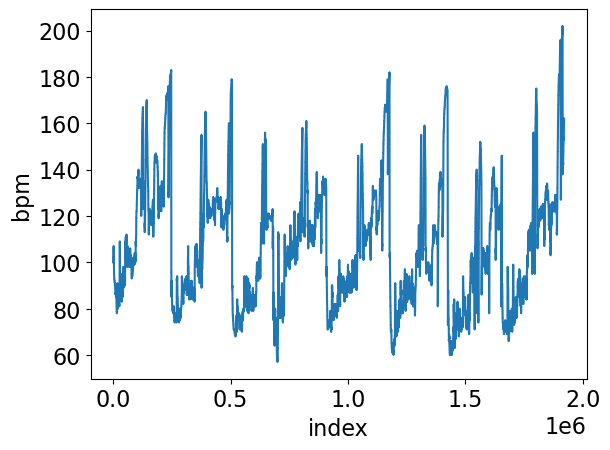

In [128]:
# **Exploring BPM trends to inform interpolation:**

# **Creating a temporary index for visualization:**
# - Facilitates visual analysis of BPM patterns
subjects['index'] = range(len(subjects))

# **Visualizing BPM progression:**
# - Uncovers patterns, trends, and potential anomalies
sns.lineplot(data=subjects, x='index', y='bpm')

# **Displaying the plot:**
# - Enables visual inspection to guide interpolation decisions
plt.show()


In [129]:
# **Imputing missing values using linear interpolation:**

# Interpolate missing values within each column:
# - Fills NaNs with values estimated along a linear trend
subjects = subjects.interpolate(method='linear')


We have now dropped all missing values for the IMU measurement units and interpolated all missing values in the heart-rate feature and we can see that it hasn't changed the picture of our bpm.

In [130]:
subjects.isnull().sum()

timestamp         0
activityID        0
bpm               4
hand_temp         0
hand_acc_16_y     0
hand_acc_6_x      0
hand_acc_6_y      0
hand_acc_6_z      0
hand_gyro_x       0
hand_gyro_y       0
hand_gyro_z       0
hand_mag_x        0
hand_mag_y        0
hand_mag_z        0
chest_temp        0
chest_acc_16_y    0
chest_acc_6_x     0
chest_acc_6_y     0
chest_acc_6_z     0
chest_gyro_x      0
chest_gyro_y      0
chest_gyro_z      0
chest_mag_x       0
chest_mag_y       0
chest_mag_z       0
ankle_temp        0
ankle_acc_16_y    0
ankle_acc_6_x     0
ankle_acc_6_y     0
ankle_acc_6_z     0
ankle_gyro_x      0
ankle_gyro_y      0
ankle_gyro_z      0
ankle_mag_x       0
ankle_mag_y       0
ankle_mag_z       0
id                0
index             0
dtype: int64

Still 4 missing values. Interpolation calculates values before and after the NaN-values, so if the first and last values are NaN they will not change. Because there are only 4 values I feel safe with removing them without compromising the dataset.

In [131]:
# **Removing rows with missing values across all columns:**
# - Ensures consistency for subsequent analyses that require complete data
subjects = subjects.dropna()


Handle Duplicate Values


In [132]:
subjects.duplicated().sum()


0

Get data information after cleaning


In [133]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1921427 entries, 2932 to 2872019
Data columns (total 38 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       float64
 1   activityID      object 
 2   bpm             float64
 3   hand_temp       float64
 4   hand_acc_16_y   float64
 5   hand_acc_6_x    float64
 6   hand_acc_6_y    float64
 7   hand_acc_6_z    float64
 8   hand_gyro_x     float64
 9   hand_gyro_y     float64
 10  hand_gyro_z     float64
 11  hand_mag_x      float64
 12  hand_mag_y      float64
 13  hand_mag_z      float64
 14  chest_temp      float64
 15  chest_acc_16_y  float64
 16  chest_acc_6_x   float64
 17  chest_acc_6_y   float64
 18  chest_acc_6_z   float64
 19  chest_gyro_x    float64
 20  chest_gyro_y    float64
 21  chest_gyro_z    float64
 22  chest_mag_x     float64
 23  chest_mag_y     float64
 24  chest_mag_z     float64
 25  ankle_temp      float64
 26  ankle_acc_16_y  float64
 27  ankle_acc_6_x   float64
 28  ankle_acc_6_y 

In [134]:
subjects.groupby('id')['bpm'].count()

id
101    247204
102    259128
103    173341
104    228385
105    269311
106    248080
107    230377
108    259215
109      6386
Name: bpm, dtype: int64

# Exploratory Data Analysis (EDA)

## Boxplot

a boxplot will show the overall distribution for each label.

To identify all features, I will first standardize the dataset. By standardizing the data, we make it easier to display labels with really large values and really small values. 

Need to drop activityID seeing as it is not a numeric feature label

In [135]:
# **Feature Scaling:**

# **Isolate numeric columns:**
numeric_cols = subjects.drop(['activityID'], axis=1)  # Separate numerical features

# **Standardize features for consistency:**
scaler = StandardScaler().fit(numeric_cols)  # Learn scaling parameters from data
scaled_subjects = scaler.transform(numeric_cols)  # Apply scaling to numerical features

# **Reconstruct DataFrame with scaled features:**
scaled_subjects = pd.DataFrame(scaled_subjects)  # Create DataFrame
scaled_subjects.columns = numeric_cols.columns  # Assign original column names

# **Preview scaled data:**
scaled_subjects.head()  # Examine a sample of the scaled dataset


,timestamp,bpm,hand_temp,hand_acc_16_y,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_acc_6_y,ankle_acc_6_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,id,index
0,-1.518731,-0.271715,-1.332558,1.160907,0.534777,0.626153,1.134043,0.558287,0.546725,-0.053495,...,0.687540,0.047972,-0.235685,0.713666,-0.006002,-0.023501,-0.003943,-1.559988,-1.529699,-1.732050
1,-1.518722,-0.271715,-1.332558,1.124092,0.534934,0.605838,1.131667,0.553718,0.562061,0.047452,...,0.637941,0.040533,-0.235683,0.718108,-0.003825,0.011192,0.001304,-1.621021,-1.529699,-1.732048
2,-1.518713,-0.271715,-1.332558,1.178627,0.584106,0.587387,1.139283,0.592717,0.565735,0.143184,...,0.637762,0.052959,-0.237795,0.722381,0.025623,0.002712,-0.004213,-1.633335,-1.529699,-1.732046
3,-1.518704,-0.271715,-1.332558,1.165254,0.589415,0.528700,1.151589,0.620195,0.561785,0.150342,...,0.628009,0.043026,-0.237797,0.722473,-0.016439,0.027431,0.002520,-1.634521,-1.529699,-1.732044
4,-1.518695,-0.271715,-1.332558,1.152867,0.611471,0.508829,1.146737,0.629406,0.542618,0.153185,...,0.697293,0.043027,-0.231447,0.722431,0.027880,0.085874,-0.006730,-1.645419,-1.529699,-1.732043


**Visualizing distributions of scaled features:**


 **Key insights from the box plot:**
Central tendencies:Observe median values for each feature.
Variability: Assess the spread of values within each feature.
Outliers: Identify potential outliers that deviate significantly.
Comparisons:Compare distributions across different features.
Feature engineering:Guide feature scaling or transformation decisions.
Pattern identification: Explore patterns or relationships between features.

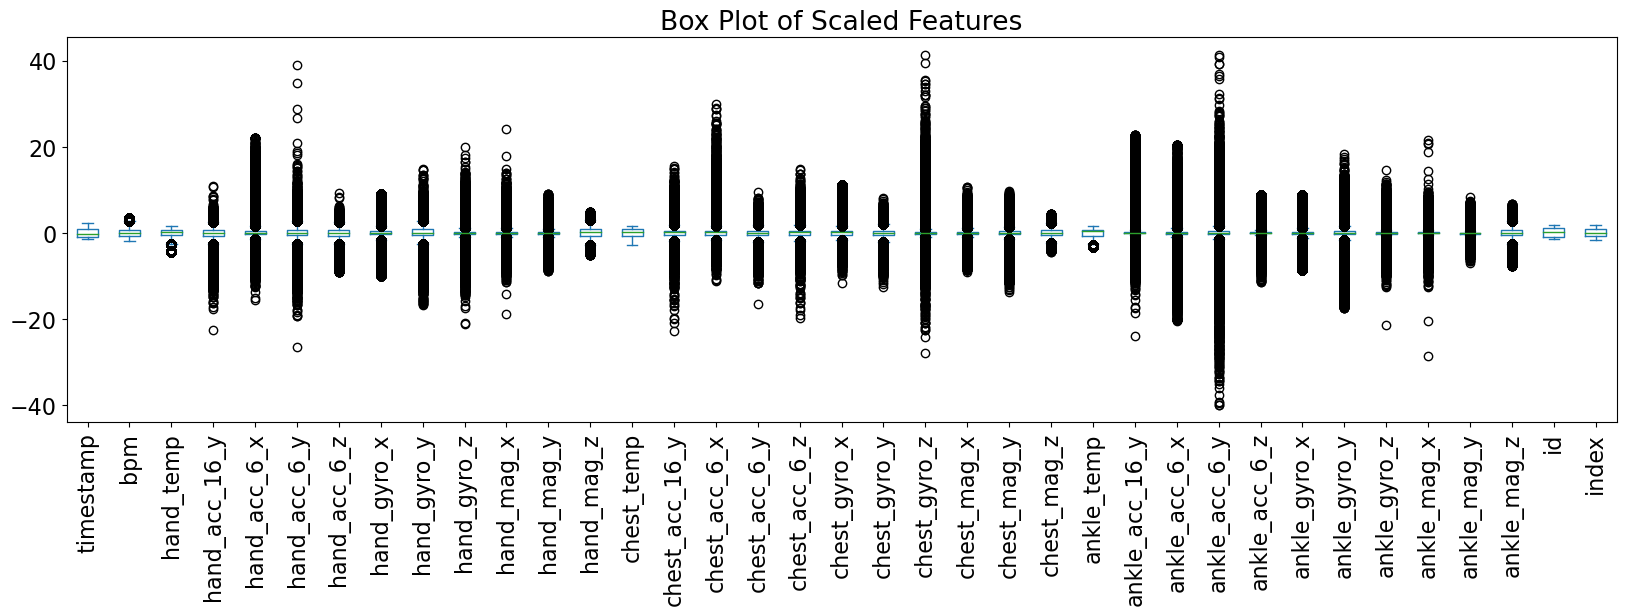

In [155]:
# **Generate box plot for comprehensive overview:**
scaled_subjects.plot(kind='box', figsize=(20, 5), title='Box Plot of Scaled Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()  # Display the plot


While the dataset exhibits a high frequency of outliers, their inclusion is deemed acceptable given their consistency with the broader patterns observed within the features.

## Shape and size or the dataset

**Reindexing and summarizing dataset structure:**


In [156]:

# **Reset index for consistency:**
subjects.reset_index(drop=True, inplace=True)  # Ensure a clean, sequential index

# **Display key dimensions:**
print('Total Number of Data Points:', subjects.size)  # Total elements in the DataFrame
print('Data Structure:', subjects.shape)  # Number of rows and columns
print('Number of Features:', len(subjects.columns))  # Count of unique features

Total Number of Data Points: 73014226
Data Structure: (1921427, 38)
Number of Features: 38


I visualized summary statistics of the data by employing pandas describe method.



In [157]:
subjects.describe()


,timestamp,bpm,hand_temp,hand_acc_16_y,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_acc_6_y,ankle_acc_6_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,id,index
count,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,...,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06,1.921427e+06
mean,1.695398e+03,1.073274e+02,3.276112e+01,-4.933060e+00,3.581012e+00,3.614215e+00,-4.865630e+00,3.569798e+00,3.799027e+00,9.737701e-04,...,-2.592587e+00,9.356581e+00,-6.848440e-02,-2.173805e+00,8.082086e-03,-3.399397e-02,1.527132e-03,-3.153360e+01,1.045684e+02,9.607170e+05
std,1.091502e+03,2.696704e+01,1.790633e+00,6.231438e+00,6.876811e+00,3.958099e+00,6.236828e+00,6.574796e+00,3.944435e+00,1.326007e+00,...,3.910121e+00,6.049128e+00,7.144780e+00,3.460594e+00,1.121348e+00,6.333409e-01,1.992153e+00,1.837860e+01,2.332763e+00,5.546683e+05
min,3.120000e+01,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,-2.813540e+01,...,-1.589260e+02,-6.030670e+01,-6.190640e+01,-6.231480e+01,-2.399500e+01,-1.812690e+01,-1.401960e+01,-1.728650e+02,1.010000e+02,4.000000e+00
25%,7.394500e+02,8.600000e+01,3.168750e+01,-8.954100e+00,1.053950e+00,1.165510e+00,-8.852120e+00,1.051560e+00,1.369735e+00,-3.756385e-01,...,-3.807295e+00,8.396790e+00,-2.085940e+00,-3.396150e+00,-2.041555e-01,-1.032145e-01,-4.298170e-01,-4.170310e+01,1.020000e+02,4.803605e+05
50%,1.467160e+03,1.040000e+02,3.318750e+01,-5.421070e+00,3.524910e+00,3.444250e+00,-5.346580e+00,3.564940e+00,3.678230e+00,-6.034280e-03,...,-2.417420e+00,9.548690e+00,-2.268760e-01,-1.988740e+00,4.584070e-03,-3.821090e-03,-2.250020e-03,-3.393250e+01,1.050000e+02,9.607170e+05
75%,2.654610e+03,1.240000e+02,3.406250e+01,-9.359535e-01,6.455530e+00,6.542860e+00,-8.871965e-01,6.458830e+00,6.790780e+00,3.314805e-01,...,-1.043240e+00,1.025460e+01,1.907190e+00,-5.943960e-01,1.272095e-01,1.152480e-01,8.914350e-02,-1.776930e+01,1.070000e+02,1.441074e+06
max,4.245680e+03,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,2.641580e+01,...,1.588720e+02,6.196930e+01,6.204900e+01,6.093570e+01,1.644270e+01,1.358820e+01,1.652880e+01,9.155160e+01,1.090000e+02,1.921430e+06


The output above show that the mean BPM is about 107. The maximum is 202.
 which might be indicative of an outlier probably as a result of a malfunction from the heartrate monitor or vigorous activities performed at that time.

### BMI
Let's now see which subject has the highest BMI:

$ BMI = \frac{weight (kg)}{height (m)^2} $

In [139]:
# **Calculating BMI for each subject:**
subject_info['bmi'] = subject_info['Weight (kg)'] / (subject_info['Height (cm)']/100)**2

# **Display the updated DataFrame with BMI:**
subject_info

,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
101,Male,27,182,83,75,193,right,25.057360
102,Female,25,169,78,74,195,right,27.309968
103,Male,31,187,92,68,189,right,26.309017
104,Male,24,194,95,58,196,right,25.241790
105,Male,26,180,73,70,194,right,22.530864
106,Male,26,183,69,60,194,right,20.603780
107,Male,23,173,86,60,197,right,28.734672
108,Male,32,179,87,66,188,left,27.152711
109,Male,31,168,65,54,189,right,23.030045


 **Interpretation:**
Understanding the typical BMI range among subjects.
Assessing the extent of BMI variation within the group.
Exploreing potential factors influencing extreme BMI values.
Considering implications for health outcomes or analysis.

In [140]:
# **Exploring BMI characteristics within the subject information:**

# **Calculate key descriptive statistics:**
print(f"Mean BMI: {np.mean(subject_info['bmi'])}")  # Quantify central tendency
print(f"St.Dev BMI: {np.std(subject_info['bmi'])}")  # Assess variability

# **Identify individuals with extreme BMI values:**
display(subject_info[max(subject_info['bmi']) == subject_info['bmi']])  # Highlight individual(s) with highest BMI
display(subject_info[min(subject_info['bmi']) == subject_info['bmi']])  # Highlight individual(s) with lowest BMI

Mean BMI: 25.107800803931557
St.Dev BMI: 2.4696531234741834


,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
107,Male,23,173,86,60,197,right,28.734672


,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
106,Male,26,183,69,60,194,right,20.60378


BMI, a measure of body mass relative to height, provides some insight into the subjects' weight categories:

* =< 18.5 = Underweight
* => 25 = Normal weight
* => 28.9 = Overweight
* =< 29 = Obese

While subject 107 falls into the "overweight" category, this classification doesn't necessarily indicate poor health. Muscle mass, along with fat, can contribute to a higher BMI. Examining the mean BMI of around 25 suggests the group generally falls within the normal weight range. This suggests that, based solely on BMI, no participants were likely in very poor physical health at the time of testing. However, it's important to remember that BMI is just one indicator of health, and factors like muscle composition and individual circumstances should be considered for a more holistic understanding

##  SUBJECT ANALYSIS

In this subsection, I analysed the users / subjects with the timestamp of the activities they performed. I first of all define a plot function to enable me create plots more eaaily.

In [161]:
# **Function to streamline bar plot creation:**
def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    a = ax.set_xticklabels(pd[column_b], rotation = (90))
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11896\1550255319.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(pd[column_b], rotation = (90))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


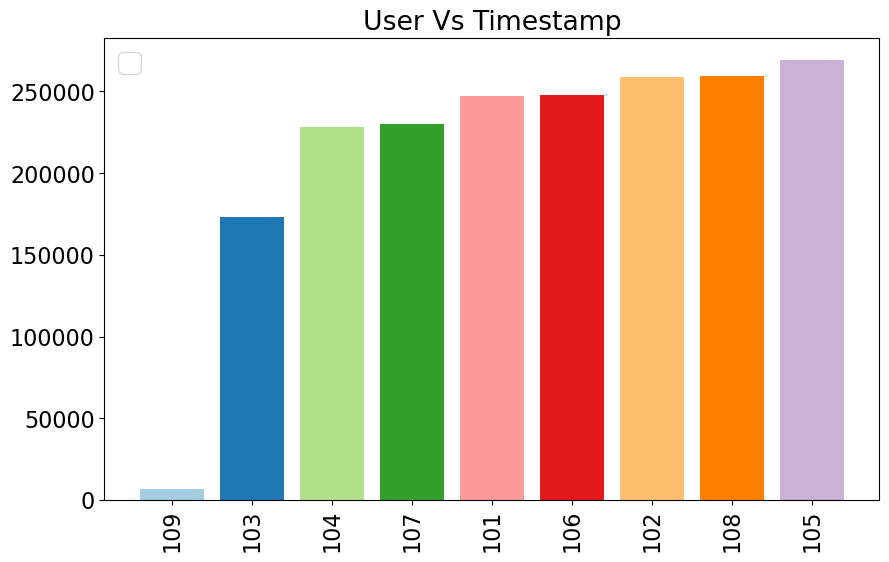

In [162]:
#Get required data and plot with defined function

sample = subjects.groupby(['id']).count().reset_index()
sample_to_subject = pd.DataFrame()
sample_to_subject['id'] = sample['id']
sample_to_subject['sample'] = sample['timestamp']
sample_to_subject = sample_to_subject.sort_values(by=['sample'])
pd_fast_plot(sample_to_subject,'sample','id','User Vs Timestamp')

Subject Activity:
Subject 9 had the least recorded activity, potentially due to device issues. Removal of their data might be necessary.
Subject 5 had the highest recorded activity.

Activity Distribution:
Walking was the most frequent activity, aligning with its prevalence in daily life.
Rope jumping was the least frequent activity.

Key Considerations:
Evaluate the impact of excluding subject 9's data.
Explore factors influencing activity patterns.
Consider implications for health interventions and technologies.

C:\Users\Win10\AppData\Local\Temp\ipykernel_11896\1550255319.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(pd[column_b], rotation = (90))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


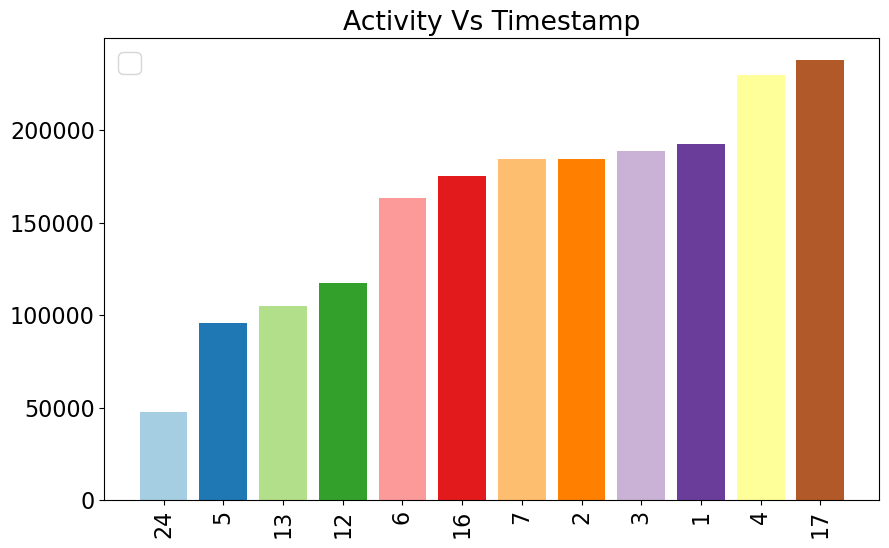

In [163]:
#Get required data and plot with defined function

sample = subjects.groupby(['activityID']).count().reset_index()
sample_to_subject = pd.DataFrame()
sample_to_subject['activity'] = [activities[x] for x in sample['activityID']]
sample_to_subject['sample'] = sample['timestamp']
sample_to_subject = sample_to_subject.sort_values(by=['sample'])
pd_fast_plot(sample_to_subject,'sample','activity','Activity Vs Timestamp')

## Analysing Temperature

In this section, I examined the average temperature readings from the arms, forehead, and lower legs of different people. Overall, the highest temperature gradient was from the forehead, while the arms were the lowest. A decrease in temperature can be observed in all three readings. This can be explained from the previous plot titled User Vs Timestamp that Subject 9 showed less unrecorded activity. The minimum temperature recorded for this case is therefore expected to deviate from the general trend seen in the figures below.

Text(0, 0.5, 'Degrees celsius')

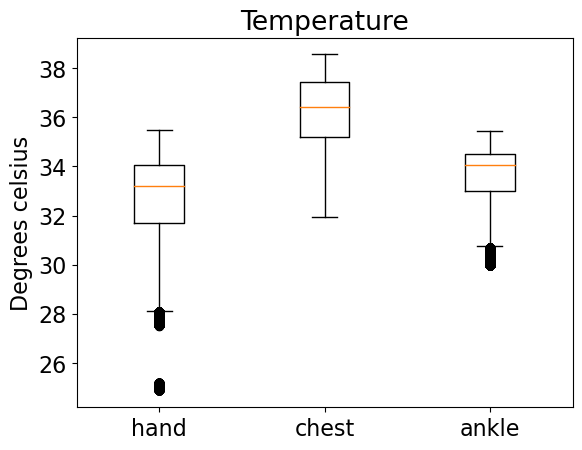

In [164]:
# **Visualizing temperature distributions across body locations:**

# **Construct informative box plot:**
plt.boxplot([subjects['hand_temp'], subjects['chest_temp'], subjects['ankle_temp']], labels=['hand', 'chest', 'ankle'])
plt.title('Temperature')
plt.ylabel('Degrees celsius')

- Comparing temperature patterns for different body locations within and across subjects.
- Identifying subjects with consistently higher or lower temperatures.
- Exploring potential correlations between body locations.
- Investigating factors influencing individual temperature variability (e.g., activity levels, physiological differences).
- Considering implications for understanding temperature regulation and health monitoring.

E:\Sussex\install\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


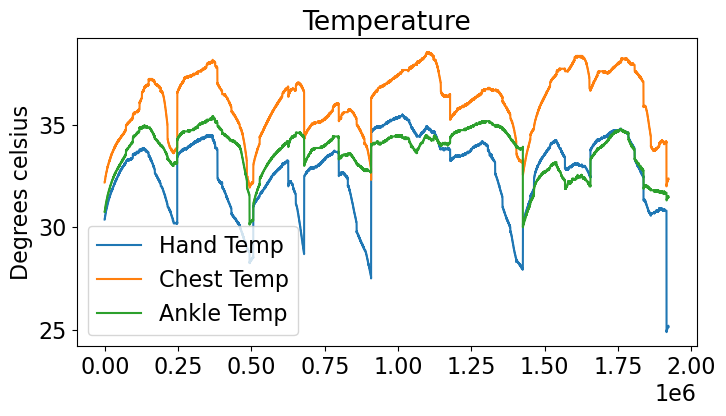

In [165]:
# **Calculate mean temperature values for each subject:**
plt.figure(figsize=(8, 4))
plt.plot(subjects['hand_temp'], label='Hand Temp')
plt.plot(subjects['chest_temp'], label='Chest Temp')
plt.plot(subjects['ankle_temp'], label='Ankle Temp')
plt.legend()
plt.title('Temperature')
plt.ylabel('Degrees celsius')
plt.show()


- big drop occur as the dataset descends to the next subjects.
- It can be seen that the average temperature of the **hands** is the lowest, and the temperature of the **chest** is the highest

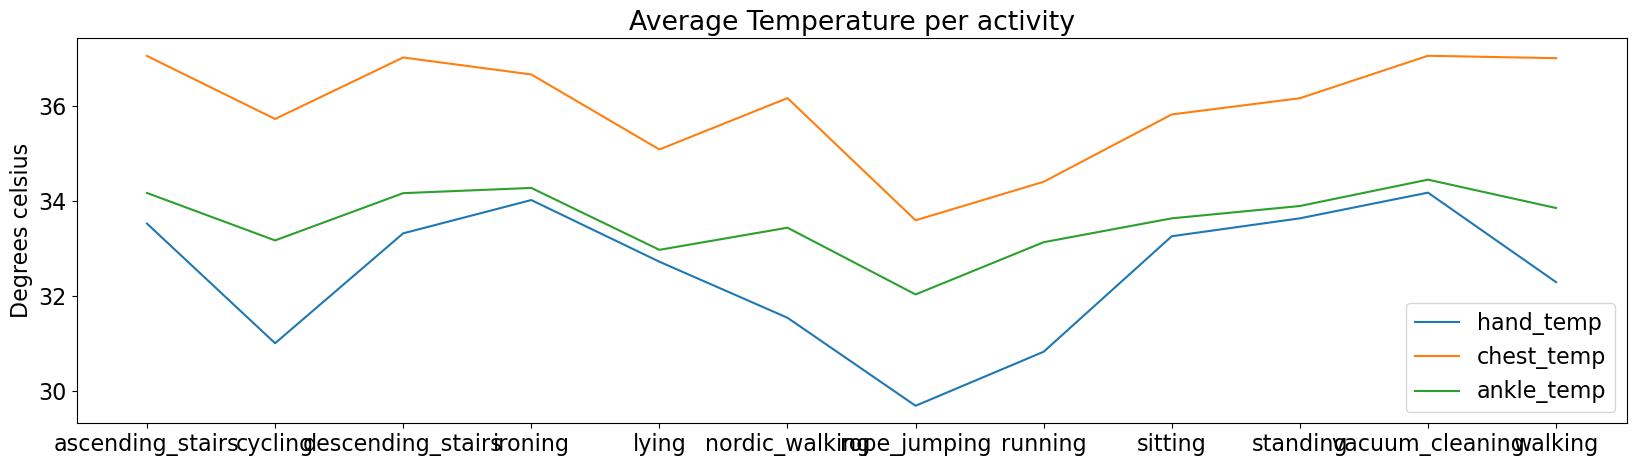

In [166]:
act_temp = subjects.groupby(['activityID']).mean().index
hand_temp = subjects.groupby(['activityID']).mean()['hand_temp']
chest_temp = subjects.groupby(['activityID']).mean()['chest_temp']
ankle_temp = subjects.groupby(['activityID']).mean()['ankle_temp']

plt.figure(figsize=(20, 5))
plt.plot(act_temp, hand_temp, label='hand_temp')
plt.plot(act_temp, chest_temp, label='chest_temp')
plt.plot(act_temp, ankle_temp, label='ankle_temp')
plt.title('Average Temperature per activity')
plt.legend()
plt.ylabel('Degrees celsius')
plt.show()

Jump roping is the coolest activity. This is surprising and probably a mistake to realize as it can be quite severe. This could be due to underrepresentation in the dataset.

## Analysing activities

To counts the occurrences of each unique value within the activityID column of the subjects DataFrame.
and then presenting the results as a frequency table, indicating how often each activity was recorded.

In [167]:
subjects['activityID'].value_counts()


activityID
ironing              237902
walking              229709
lying                192286
standing             188984
sitting              184645
nordic_walking       184444
vacuum_cleaning      174976
cycling              163302
ascending_stairs     117094
descending_stairs    104865
running               95641
rope_jumping          47579
Name: count, dtype: int64

Text(0.5, 1.0, "BPM's for each activity")

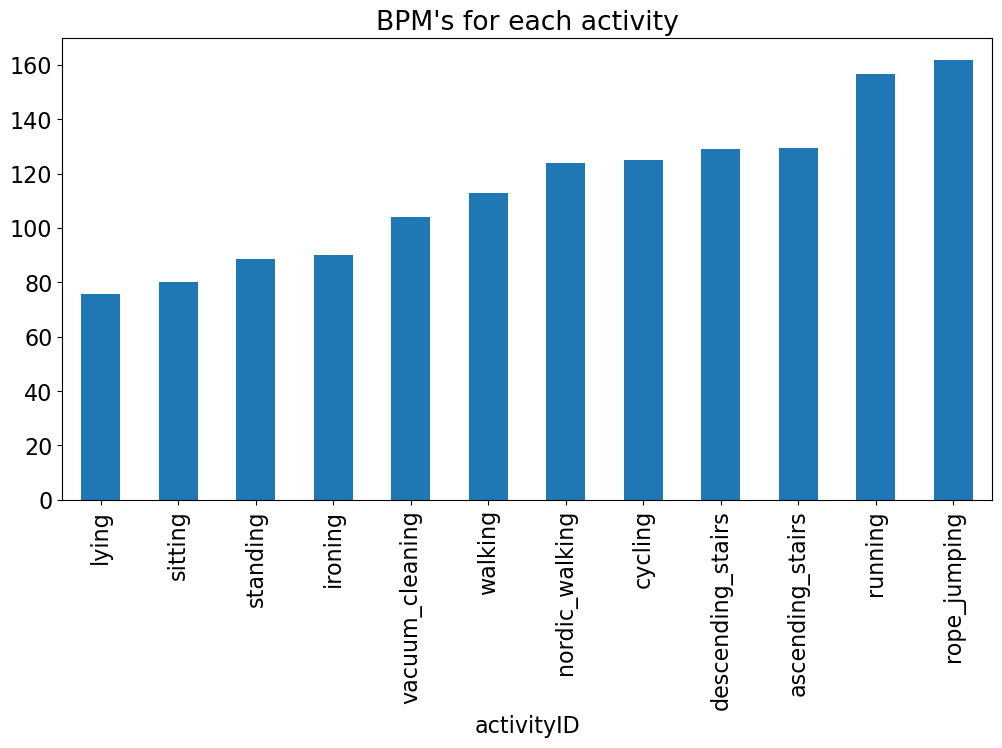

In [168]:
subjects.groupby('activityID')['bpm'].mean().sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("BPM's for each activity")

The bar graph shows that activity, jumping rope and running are the most taxing with BPM above 150bpm, while climbing stairs, cycling which we can consider as moderate activity and sitting and sleeping are the least taxing BPM between 70 - 80 bpm.

In [169]:
subjects.groupby('activityID')['bpm'].mean().sort_values(ascending=False)

activityID
rope_jumping         161.810903
running              156.646900
ascending_stairs     129.531574
descending_stairs    129.158759
cycling              124.899581
nordic_walking       123.816170
walking              112.768643
vacuum_cleaning      104.191229
ironing               90.067612
standing              88.552778
sitting               80.015589
lying                 75.534206
Name: bpm, dtype: float64

### BPM Analysis

The focus of the analysis in this subsection is bpm, which is the most accurate meter for tracking topics activities using the instructions from the provided readme file Below I look at the bpm classification of a bpm monitor has been written for various topics.

C:\Users\Win10\AppData\Local\Temp\ipykernel_11896\3370574717.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subjects['bpm'], fit=norm)


<Axes: xlabel='bpm', ylabel='Density'>

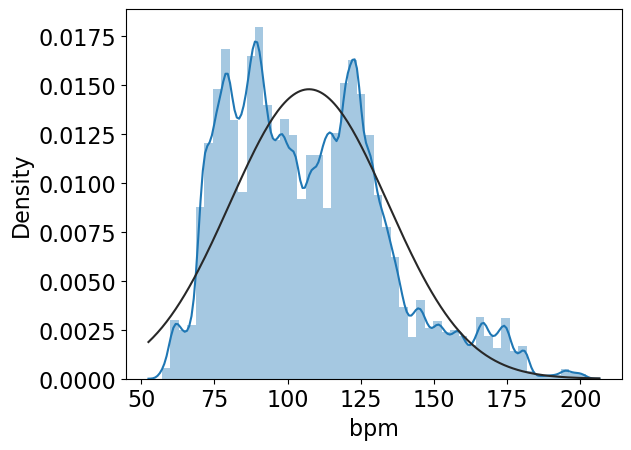

In [170]:
sns.distplot(subjects['bpm'], fit=norm)

Heartrate Distribution:

- The distribution plot reveals a positive skew, meaning most values cluster towards the lower end, with a longer tail extending to higher heart rates.
- This asymmetry is further illustrated by the boxplot, which highlights the majority of heart rates concentrated between 86 and 124, while values above 180 stand out as potential outliers.
- Although outliers can influence the mean and certain analyses assuming normality, they'll be retained for this analysis to preserve the integrity of the heartrate data.

Key Points:
- Positive skew indicates a concentration of values on the lower end, with a tail extending to higher values.
- Mean typically exceeds median and mode in positively skewed distributions.
- Boxplots effectively visualize central tendencies and outliers.
- Outlier presence can impact certain statistical analyses.

<Axes: ylabel='bpm'>

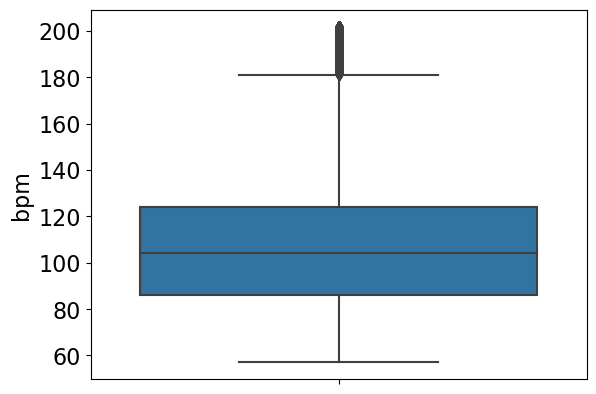

In [171]:
sns.boxplot(y=subjects['bpm'])

When rigorous or tasking activities are performed, BPM is expected to be higher. Here, I plot a barchart to visualze the BPM for each activity performed

## Correlation heatmap

To delve into potential relationships between variables and uncover any anomalies, I harnessed the power of correlation analysis. While the numerical correlation table provided valuable insights, a visually compelling heatmap, generated using Seaborn, further illuminated these relationships and facilitated the identification of patterns and outliers.

The heatmap will show the linear relationships between every label in the dataset. White is high correlation, red is medium and black is low.

<Axes: >

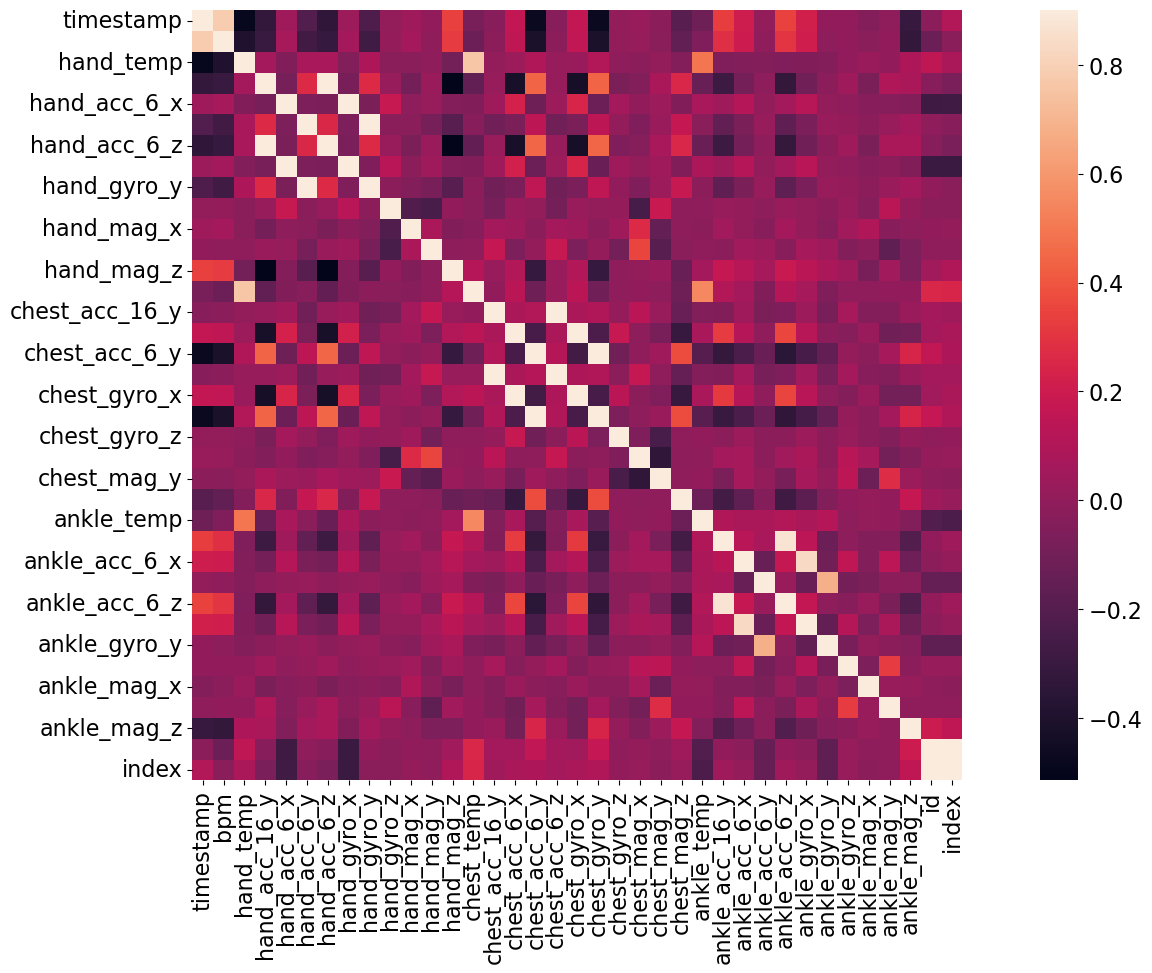

In [172]:
corrmat = subjects.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(20,10))
sns.heatmap(corrmat, vmax=0.9, square=True)


The heatmap reveals intriguing relationships between sensor readings on the chest. Notably, "Chest_Mag_z" exhibits a strong inverse relationship with both "Chest_Acc16_y" and "Chest_Acc6_z," meaning their values tend to oppose each other. Conversely, "chestTemperature" shows a clear positive correlation with "ankleTemperature," suggesting they rise and fall in tandem. Further exploration may uncover additional meaningful relationships within the data.


# Hypothesis Testing

Based on our temperature analysis, we hypothesize that body temperature during indoor activities, like household chores, will be significantly higher than during outdoor activities like running or cycling. This would suggest that external temperature has a greater influence on body temperature than physical activity level. Testing this hypothesis could provide valuable insights for managing activities and attire in cold environments.

In [173]:
# **Isolate data for indoor and outdoor activities:**
# **Indoor activities:**
ironing = subjects[subjects['activityID'] == 'ironing']  # Select data for ironing
vacuum_cleaning = subjects[subjects['activityID'] == 'vacuum_cleaning']  # Select data for vacuum cleaning
inside = pd.concat([ironing, vacuum_cleaning])  # Combine data for both indoor activities

# **Outdoor activities:**
running = subjects[subjects['activityID'] == 'running']  # Select data for running
cycling = subjects[subjects['activityID'] == 'cycling']  # Select data for cycling
rope_jumping = subjects[subjects['activityID'] == 'rope_jumping']  # Select data for rope jumping
nordic_walking = subjects[subjects['activityID'] == 'nordic_walking']  # Select data for nordic walking
outside = pd.concat([running, cycling, rope_jumping, nordic_walking])  # Combine data for all outdoor activities

# **Calculate mean chest temperatures for comparison:**
print(f"Mean chest temp for household chores: {np.mean(inside['chest_temp'])}")  # Assess temperature during indoor activities
print(f"Mean chest temp for outside activities: {np.mean(outside['chest_temp'])}")  # Assess temperature during outdoor activities

Mean chest temp for household chores: 36.831630802561534
Mean chest temp for outside activities: 35.4292803625913


To perform this hypthesis I will use the Z-test:

The Z-test is measured with the following Test Statistic: $ Z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} $

Our level of significance will be 5%

$ H_0 = $ outside activities $ \le 35.4293 $

$ H_A = $ outside activities $ > 35.4293 $

In [174]:
# **Conduct a one-sample z-test to compare temperatures:**
# **Set significance level:**
alpha = 0.05
x_bar = np.mean(inside['chest_temp'])
mu = np.mean(outside['chest_temp'])
sigma = np.std(outside['chest_temp'])
N = len(outside['chest_temp'])

Z = (x_bar - mu) / (sigma - np.sqrt(N))
print(Z)

-0.002006575155173733



 **Compare the calculated z-score to the critical value at the alpha level to determine statistical significance.**
- If the z-score exceeds the critical value, reject the null hypothesis that the temperatures are equal.
- Consider assumptions of normality and known population standard deviation.
- Explore alternative tests if assumptions are not met.

In [175]:
p_value = 1 - norm.cdf(Z)
if p_value > alpha:
    print(f'The P-value is {p_value} and thus we fail to reject the null hypothesis.')
else:
    print(f'The P-value is {p_value} and thus we can reject the null hypothesis for the alternative hypothesis')

The P-value is 0.5008005071310156 and thus we fail to reject the null hypothesis.


While the p-value exceeds our chosen significance level, precluding rejection of the null hypothesis, it's important to acknowledge that this doesn't definitively confirm equal chest temperatures during indoor and outdoor activities. Future research with larger sample sizes or refined methodology might be needed to conclusively evaluate this hypothesis.

# Splitting dataset into train/test-sets
To effectively incorporate ActivityID into the models, I'll employ OneHotEncoding to represent each distinct activity as a separate binary feature, ensuring models can accurately capture activity-related patterns. I'll then split the data into a 75% training set for model development and a 25% testing set for unbiased performance evaluation.

In [176]:
# **Prepare data for modeling:**
# **Isolate relevant features:**
df = subjects.drop(['activityID', 'id'], axis=1)

ohe_df = pd.get_dummies(subjects['activityID'], prefix='act')

# **Split data for training and testing:**
x_train =  df.sample(frac=0.75, random_state=1)
x_test = df.drop(x_train.index)
y_train = ohe_df.iloc[x_train.index]
y_test = ohe_df.iloc[x_test.index]

scaler = StandardScaler()  # Ensure features have similar scales for model optimization

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=df.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=df.columns)

- Feature selection and encoding impact model performance.
- Train-test splits influence model generalization.
- Avoiding data leakage during preprocessing to ensure unbiased evaluation.

In [177]:
# **Combine activity data with main dataset:**
df = df.join(subjects['activityID'])

for key, value in activities.items():
    df.replace(key, value, inplace=True)
    
x = df.iloc[:, -1]
# **Split data into training and testing sets:**
cluster_train = df.sample(frac=0.75, random_state=1)
cluster_test = df.drop(cluster_train.index)
clf_train = x.iloc[cluster_train.index].values
clf_test = x.iloc[cluster_test.index].values

cluster_train = pd.DataFrame(scaler.fit_transform(X=cluster_train, y=cluster_train['activityID']), columns=df.columns)
cluster_test = pd.DataFrame(scaler.fit_transform(X=cluster_test, y=cluster_test['activityID']), columns=df.columns)

## Dimensionality Reduction with the use of PCA
To harness PCA effectively for dimensionality reduction, we'll first visualize the variance explained by different principal component counts to pinpoint the optimal number that captures 95% of the data's essence, striking a balance between preserving meaningful information and streamlining analysis

Text(0.5, 0, 'N componments')

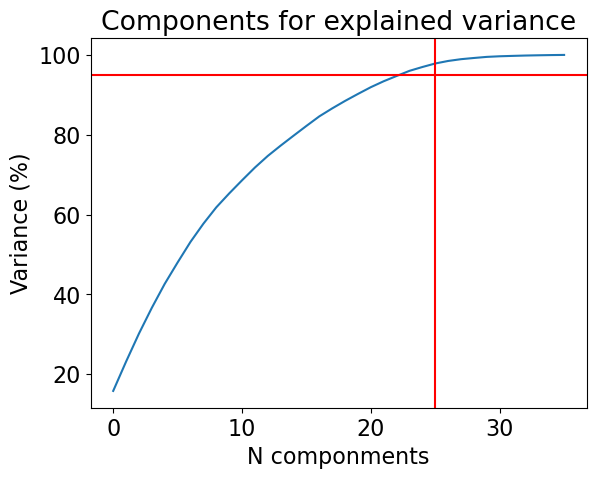

In [178]:
pca = PCA()
pca.fit(x_train)
pca_variance = np.cumsum(pca.explained_variance_ratio_) * 100

plt.plot(pca_variance)
#plt.grid()
#plt.xlim(0, 50)
#plt.ylim(90, 101)
plt.axhline(95, c='red')
plt.axvline(25, c='red')
plt.title("Components for explained variance")
plt.ylabel("Variance (%)")
plt.xlabel("N componments")

Reducing the dimensionality to 25 components will preserve 95% of the variance in our dataset, effectively capturing the most salient information while simplifying subsequent analyses.

In [179]:
pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

# Model Selection

In this section, I have employed algorithms to predictive model for this analysis. The algorithm used is:

Logistics Regression

I first of all define a function to calculate Accuracy to be used for this analysis.

In [180]:
def fit_ml_algo(algo, x_train, y_train, x_test, y_test, cv):

# Fit the algorithm to the training data:    
    model = algo.fit(x_train, y_train)
    train_pred = cross_val_predict(algo, x_train, y_train, cv=cv, n_jobs=(-1))
    test_pred = cross_val_predict(algo, x_test, y_test, cv=cv, n_jobs=(-1))
# Calculate cross-validated accuracy scores (rounded to 2 decimal places):
    train_acc_cv = round(accuracy_score(y_train, train_pred) * 100, 2)
    test_acc_cv = round(accuracy_score(y_test, test_pred) * 100, 2)
    
    return train_pred, test_pred, train_acc_cv, test_acc_cv

### Logistic Regression

The logistic regression is implemented as a linear model for classification rather than regression. It models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables. I t can be used for both binary and multivariate tasks

In [181]:
n_cv = 10 # Number of times we cross-validate the data
res = []

for col in y_train.columns:
    start_time = time.time()
    train_pred, test_pred, train_acc, test_acc = fit_ml_algo(LogisticRegression(),
                                                             x_train,
                                                             y_train[col],
                                                             x_test,
                                                             y_test[col],
                                                             n_cv)
    log_time = time.time() - start_time
    
    print(col)
    print(f"CV Accuracy Train {n_cv}-fold: {train_acc}")
    print(f'CV Accuracy Test {n_cv}-fold: {test_acc}')
    print(f"Running Time: {datetime.timedelta(seconds=log_time)}")
    print(" ") # Spacing the prints
    res.append(test_acc)

act_ascending_stairs
CV Accuracy Train 10-fold: 94.56
CV Accuracy Test 10-fold: 93.43
Running Time: 0:09:28.011488
 
act_cycling
CV Accuracy Train 10-fold: 97.37
CV Accuracy Test 10-fold: 95.38
Running Time: 0:00:31.468360
 
act_descending_stairs
CV Accuracy Train 10-fold: 95.21
CV Accuracy Test 10-fold: 94.02
Running Time: 0:00:26.444171
 
act_ironing
CV Accuracy Train 10-fold: 94.28
CV Accuracy Test 10-fold: 90.95
Running Time: 0:00:31.223929
 
act_lying
CV Accuracy Train 10-fold: 99.47
CV Accuracy Test 10-fold: 97.49
Running Time: 0:01:16.487936
 
act_nordic_walking
CV Accuracy Train 10-fold: 88.54
CV Accuracy Test 10-fold: 86.83
Running Time: 0:00:26.647111
 
act_rope_jumping
CV Accuracy Train 10-fold: 98.1
CV Accuracy Test 10-fold: 96.48
Running Time: 0:00:33.703057
 
act_running
CV Accuracy Train 10-fold: 96.3
CV Accuracy Test 10-fold: 95.67
Running Time: 0:00:33.072909
 
act_sitting
CV Accuracy Train 10-fold: 97.33
CV Accuracy Test 10-fold: 94.13
Running Time: 0:00:58.307219
 
a

In [182]:
print(f"Average accuracy: {np.mean(res)}")
print(f"Median accuracy: {np.median(res)}")
print(f"Standard Deviation of the accuracy: {np.std(res)}")

Average accuracy: 93.11000000000001
Median accuracy: 93.995
Standard Deviation of the accuracy: 3.269780828536779


While training data accuracy was generally higher, the model achieved impressively high test accuracy, exceeding 90% for most activities. This suggests good generalizability and potential for effective real-world deployment.

## Cluster Analysis 

To explore whether activities can be effectively segmented using unsupervised learning, I'll employ K-Means Clustering to group similar activities together. After initializing a cluster with all 12 activities, I'll leverage the Elbow Method to determine the optimal number of clusters for visualization. To ensure clarity in the scatter plot, I'll first utilize PCA to identify the most informative feature combinations for visual representation..

Given these insights, the most informative configuration for the plot would be:

x-axis = **Timestamp**\
y-axis = **Heart Rate (bpm)**

In [183]:
clf_train = pd.DataFrame(clf_train, columns=['train'])

kmeans = KMeans(n_clusters=len(np.unique(clf_train)), init='random')

kmeans.fit(clf_train)

identified_clusters = kmeans.fit_predict(clf_train)
clf_train['identified'] = identified_clusters
print(identified_clusters)

E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Sussex\install\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "E:\Sussex\install\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "E:\Sussex\install\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Susse

[ 3  1  3 ...  6 10  7]


E:\Sussex\install\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


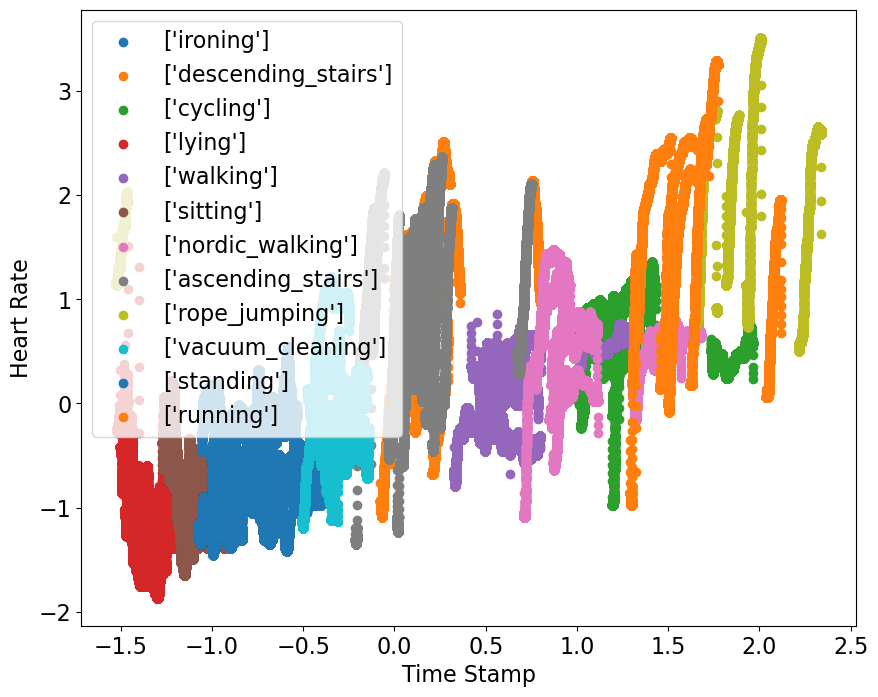

In [184]:
for key, value in activities.items():
    clf_train['train'].replace(value, key, inplace=True)

plt.figure(figsize=(10, 8))
for u in np.unique(clf_train['identified']):
    plt.scatter(cluster_train[clf_train['identified'] == u]['timestamp'],
               cluster_train[clf_train['identified'] == u]['bpm'], 
               label=np.unique(clf_train[clf_train['identified'] == u]['train']))
plt.legend()
plt.xlabel('Time Stamp')
plt.ylabel('Heart Rate')
plt.show()

While the current clustering has successfully segmented activities within the dataset, I'll explore the elbow method to potentially refine cluster definitions and potentially improve overall dataset structure.

In [185]:
wcss = []

for i in range(1, 13):
    kmeans = KMeans(i)
    kmeans.fit(pd.DataFrame(clf_train['identified'])) # The kmeans couldn't fit with anything else than a pd.DataFrame
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to supp

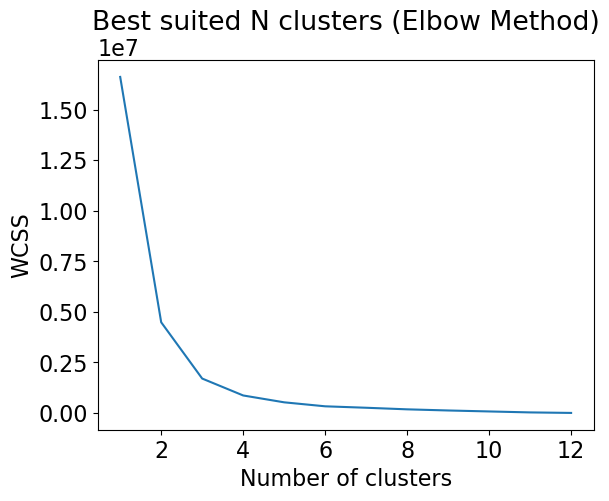

In [186]:
number_clusters = range(1, 13)
plt.plot(number_clusters, wcss)
plt.title('Best suited N clusters (Elbow Method)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the insights gleaned from the graph, we can confidently conclude that a cluster configuration of 2 strikes the optimal balance between cluster cohesion and separation, ensuring meaningful groupings within our dataset.

In [187]:
kmeans = KMeans(n_clusters=2, init='random')

kmeans.fit(pd.DataFrame(clf_train['identified']))

identified_clusters = kmeans.fit_predict(pd.DataFrame(clf_train['identified']))

E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Sussex\install\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


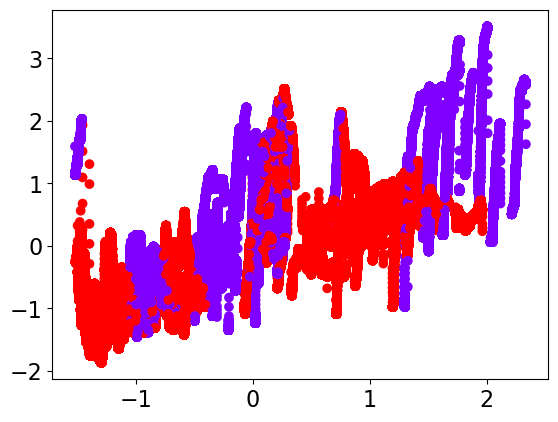

In [188]:
plt.scatter(cluster_train['timestamp'], cluster_train['bpm'], c=identified_clusters, cmap='rainbow')
plt.show()

While the Elbow Method suggests a clear cluster count, the resulting clusters themselves lack interpretability, indicating potential limitations of this method for this specific dataset and prompting exploration of alternative clustering techniques or feature representations.

# Summary

   Following meticulous data preprocessing, I embarked on a comprehensive analysis of temperature, activity types, and heart rate data. To investigate potential differences in body temperature between indoor and outdoor activities, I conducted a z-test. However, the results did not provide statistically significant evidence to support the hypothesis of higher temperatures during indoor activities.

In preparation for further modeling, I normalized the data using Standard Scaler and encoded each activity as a distinct binary feature. Employing Principal Component Analysis, I identified 24 principal components that effectively captured 95% of the data's variance. I then constructed a Logistic Regression model, which demonstrated a remarkable 93% accuracy in predicting the specific activities being performed. Extending the analysis, I employed K-Means Clustering to group the activities based on their underlying patterns. While the optimal number of clusters remained inconclusive using the Elbow Method, this clustering approach revealed potential avenues for further exploration.

In [189]:
import io
from nbformat import read
filepath="RE-2.ipynb"
with io.open(filepath, 'r', encoding='utf-8') as f:
    nb=read(f, 4)
word_count = 0
for cell in nb['cells']:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count))

Submission length is 2527
